# Predicting AI Acceptance in Mental Health Interventions through Self-Determination Theory

**Goal of this notebook**

This notebook prepares analysis-ready datasets and performs core EDA for a cross-cultural study on AI acceptance in mental health interventions.

We will:
1. Clean and merge China and USA datasets.
2. Compute all composite scale scores (SDT, Epistemic Trust, Stigma, Depression, AI Attitudes, AI Acceptance).
3. Create multiple merged dataset variants (intersection, union with suffixes, full merged).
4. Check data quality (descriptives, missingness, reliabilities).
5. Impute missing values for key hypothesis variables.

**Outputs**
- `data/china/CN_all_coalesced.csv`
- `data/merged/merged.csv`
- `data/merged/intersection.csv`
- `data/merged/union_with_suffix.csv`

## 0.0. Setup & Paths

In [82]:
from __future__ import annotations

import warnings
from pathlib import Path
from typing import List, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

DATA_DIR = Path("data")
MERGED_DIR = DATA_DIR / "merged"
CHINA_DIR = DATA_DIR / "china"
USA_DIR = DATA_DIR / "usa"

MERGED_DIR.mkdir(parents=True, exist_ok=True)

## 1.0. Load and Prepare China Data

China has three separate files that need to be coalesced:
- CN_all.csv - Combined sample
- CN_client.csv - Client-specific items
- CN_therapist.csv - Therapist-specific items

In [83]:
cn_all = pd.read_csv(CHINA_DIR / "CN_all.csv")
cn_client = pd.read_csv(CHINA_DIR / "CN_client.csv")
cn_therapist = pd.read_csv(CHINA_DIR / "CN_therapist.csv")

print(f"CN_all: {cn_all.shape}")
print(f"CN_client: {cn_client.shape}")
print(f"CN_therapist: {cn_therapist.shape}")

CN_all: (485, 514)
CN_client: (216, 565)
CN_therapist: (269, 565)


In [84]:
cn_all.head()

,ID,responsetime,workinmh,workinmh_text,mh_service,receive_mh_service,age,gender,ethnicity,province,...,UTAUT_chatbot6,UTAUT_chatbot16,UTAUT_chatbot17,UTAUT_chatbot18,UTAUT_chatbot19,UTAUT_chatbot20,UTAUT_chatbot21,UTAUT_chatbot23,UTAUT_chatbot24,filter_$
0,380.0,3853.0,2.0,NaN,1.0,2.0,10.0,3.0,0.0,陕西省,...,2.0,2.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,0.0
1,269.0,1778.0,2.0,NaN,1.0,1.0,17.0,3.0,0.0,上海市,...,1.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0
2,73.0,1810.0,2.0,NaN,1.0,2.0,2.0,3.0,0.0,黑龙江省,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0
3,544.0,2001.0,1.0,NaN,2.0,2.0,7.0,3.0,0.0,北京市,...,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0
4,415.0,1523.0,2.0,NaN,1.0,1.0,1.0,3.0,0.0,内蒙古自治区,...,3.0,3.0,2.0,3.0,2.0,3.0,2.0,2.0,3.0,1.0


### 1.1. Merge Client and Therapist Data into CN_all

Client and therapist files have additional items not in CN_all. We'll merge them in.

#### 1.1.1. Identify columns that are present in client/therapist but missing from CN_all

In [85]:
# Find columns unique to client/therapist files
all_cols = set(cn_all.columns)
client_cols = set(cn_client.columns)
ther_cols = set(cn_therapist.columns)

# Columns that exist in client/therapist but not in all
missing_from_all = sorted(list((client_cols | ther_cols) - all_cols))

print(f"Found {len(missing_from_all)} columns to add from client/therapist files")
print(f"Examples: {missing_from_all[:5]}")

Found 53 columns to add from client/therapist files
Examples: ['AI_use_sum', 'AIavatar_CO_mean', 'AIavatar_EOU_mean', 'AIavatar_HC_mean', 'AIavatar_HM_mean']


In [86]:
# Get columns that overlap between client and therapist
overlap_cols = sorted(list(set(missing_from_all).intersection(client_cols).intersection(ther_cols)))
print(f"{len(overlap_cols)} columns exist in both client and therapist files")

53 columns exist in both client and therapist files


#### 1.1.2. Prepare extra columns from each files

In [87]:
# Add suffixes to distinguish source
client_extra_cols = [c for c in missing_from_all if c in cn_client.columns]
therapist_extra_cols = [c for c in missing_from_all if c in cn_therapist.columns]

In [88]:
# Create separate dataframes with just ID and the extra columns
client_extra = cn_client[["ID"] + client_extra_cols].copy()
therapist_extra = cn_therapist[["ID"] + therapist_extra_cols].copy()

In [89]:
# Add suffixes to overlapping columns
client_extra = client_extra.rename(columns={c: f"{c}_client" for c in client_extra_cols})
therapist_extra = therapist_extra.rename(columns={c: f"{c}_therapist" for c in therapist_extra_cols})

In [90]:
# Merge into cn_all
cn_augmented = cn_all.merge(client_extra, on="ID", how="left")
cn_augmented = cn_augmented.merge(therapist_extra, on="ID", how="left")
print(f"Augmented CN_all from {cn_all.shape} to {cn_augmented.shape}")

Augmented CN_all from (485, 514) to (485, 620)


In [91]:
cn_augmented.head()

,ID,responsetime,workinmh,workinmh_text,mh_service,receive_mh_service,age,gender,ethnicity,province,...,chatbot_CO_mean_therapist,chatbot_EOU_mean_therapist,chatbot_HC_mean_therapist,chatbot_HM_mean_therapist,chatbot_PPR_mean_therapist,chatbot_SE_mean_therapist,chatbot_TQE_mean_therapist,chatbot_mean_therapist,stagesAI_mean_therapist,therapist_filter_therapist
0,380.0,3853.0,2.0,NaN,1.0,2.0,10.0,3.0,0.0,陕西省,...,3.0,3.5,2.75,4.0,2.5,3.5,3.666667,3.273810,4.428395,0.0
1,269.0,1778.0,2.0,NaN,1.0,1.0,17.0,3.0,0.0,上海市,...,5.0,5.0,2.00,5.0,1.0,5.0,5.000000,4.000000,5.000000,0.0
2,73.0,1810.0,2.0,NaN,1.0,2.0,2.0,3.0,0.0,黑龙江省,...,2.0,3.0,3.00,3.0,3.0,2.0,3.000000,2.714286,3.352469,0.0
3,544.0,2001.0,1.0,NaN,2.0,2.0,7.0,3.0,0.0,北京市,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,415.0,1523.0,2.0,NaN,1.0,1.0,1.0,3.0,0.0,内蒙古自治区,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2. Coalesce Client/Therapist Columns into Unified Columns

For columns that exist in both client and therapist versions, we'll coalesce them into single unified columns.

In [92]:
# Create coalesced versions of overlapping columns
cn_coalesced = cn_augmented.copy()

# Get list of base names that have both _client and _therapist versions
client_suffix_cols = [c for c in cn_coalesced.columns if c.endswith("_client")]
therapist_suffix_cols = [c for c in cn_coalesced.columns if c.endswith("_therapist")]

# Find base names that exist in both
client_bases = {c.replace("_client", "") for c in client_suffix_cols}
therapist_bases = {c.replace("_therapist", "") for c in therapist_suffix_cols}
common_bases = sorted(list(client_bases & therapist_bases))

print(f"Found {len(common_bases)} variables with client/therapist versions")
print("Examples:", common_bases[:5])

Found 53 variables with client/therapist versions
Examples: ['AI_use_sum', 'AIavatar_CO_mean', 'AIavatar_EOU_mean', 'AIavatar_HC_mean', 'AIavatar_HM_mean']


In [93]:
# For each paired column, create a unified version
for base in common_bases:
    client_col = f"{base}_client"
    therapist_col = f"{base}_therapist"
    
    # Coalesce: use client value if available, otherwise therapist value
    cn_coalesced[base] = cn_coalesced[client_col].fillna(cn_coalesced[therapist_col])

### 1.3 Add role_label Variable between Client and Therapist

Uses the presence of client/therapist data to label participants as "client" or "therapist"

In [94]:
# Use one example base to infer role if no explicit column
sample_client_col = f"{common_bases[0]}_client"
sample_ther_col = f"{common_bases[0]}_therapist"

cn_coalesced["role_label"] = "unknown"
cn_coalesced.loc[cn_coalesced[sample_client_col].notna(), "role_label"] = "client"
cn_coalesced.loc[cn_coalesced[sample_ther_col].notna(), "role_label"] = "therapist"

print("Role distribution:")
print(cn_coalesced["role_label"].value_counts())

Role distribution:
role_label
therapist    269
client       216
Name: count, dtype: int64


### 1.4. Compute Composite Scores for China 

Calculate mean scores for all multi-item scales across TENS, ET, SSRPH, PHQ5, GAAIS, UTAUT_AI.

In [95]:
# TENS_Life_mean (Self-Determination - 9 items, first 6 are reverse-coded)
tens_items = ['TENS_Life_1r', 'TENS_Life_2r', 'TENS_Life_3r', 'TENS_Life_4r', 'TENS_Life_5r', 'TENS_Life_6r',
              'TENS_Life_7', 'TENS_Life_8', 'TENS_Life_9']
tens_available = [c for c in tens_items if c in cn_coalesced.columns]
if tens_available:
    cn_coalesced['TENS_Life_mean'] = cn_coalesced[tens_available].mean(axis=1)
    print(f"TENS_Life_mean: {len(tens_available)}/9 items, Mean={cn_coalesced['TENS_Life_mean'].mean():.2f}")

TENS_Life_mean: 9/9 items, Mean=4.35


In [96]:
# ET_mean (Epistemic Trust - 15 items)
et_items = [f'ET_{i}' for i in range(1, 16)]
et_available = [c for c in et_items if c in cn_coalesced.columns]
if et_available:
    cn_coalesced['ET_mean'] = cn_coalesced[et_available].mean(axis=1)
    print(f"ET_mean: {len(et_available)}/15 items, Mean={cn_coalesced['ET_mean'].mean():.2f}")

ET_mean: 15/15 items, Mean=4.70


In [97]:
# SSRPH_mean (Stigma - 5 items)
ssrph_items = [f'SSRPH_{i}' for i in range(1, 6)]
ssrph_available = [c for c in ssrph_items if c in cn_coalesced.columns]
if ssrph_available:
    cn_coalesced['SSRPH_mean'] = cn_coalesced[ssrph_available].mean(axis=1)
    print(f"SSRPH_mean: {len(ssrph_available)}/5 items, Mean={cn_coalesced['SSRPH_mean'].mean():.2f}")

SSRPH_mean: 5/5 items, Mean=2.30


In [98]:
# PHQ5_mean (Depression - 5 items)
phq_items = [f'PHQ5_{i}' for i in range(1, 6)]
phq_available = [c for c in phq_items if c in cn_coalesced.columns]
if phq_available:
    cn_coalesced['PHQ5_mean'] = cn_coalesced[phq_available].mean(axis=1)
    print(f"PHQ5_mean: {len(phq_available)}/5 items, Mean={cn_coalesced['PHQ5_mean'].mean():.2f}")

PHQ5_mean: 5/5 items, Mean=1.53


In [99]:
# GAAIS_mean (General AI Attitudes - using existing GAAIS_pos and GAAIS_neg if available)
if 'GAAIS_pos' in cn_coalesced.columns and 'GAAIS_neg' in cn_coalesced.columns:
    # Overall is average of positive and (reversed) negative
    cn_coalesced['GAAIS_mean'] = (cn_coalesced['GAAIS_pos'] + (8 - cn_coalesced['GAAIS_neg'])) / 2
    print(f"GAAIS_mean: computed from pos/neg subscales, Mean={cn_coalesced['GAAIS_mean'].mean():.2f}")
elif 'GAAIS_mean' not in cn_coalesced.columns:
    # Compute from individual items
    gaais_items = [f'GAAIS_{i}' for i in range(1, 11)]
    gaais_available = [c for c in gaais_items if c in cn_coalesced.columns]
    if gaais_available:
        cn_coalesced['GAAIS_mean'] = cn_coalesced[gaais_available].mean(axis=1)
        print(f"GAAIS_mean: {len(gaais_available)} items, Mean={cn_coalesced['GAAIS_mean'].mean():.2f}")

GAAIS_mean: computed from pos/neg subscales, Mean=4.57


In [100]:
# UTAUT_AI_mean (AI Acceptance - 26 items)
utaut_ai_items = [f'UTAUT_AI{i}' for i in range(1, 27)]
utaut_ai_items_with_r = []
for i in range(1, 27):
    if f'UTAUT_AI{i}r' in cn_coalesced.columns:
        utaut_ai_items_with_r.append(f'UTAUT_AI{i}r')
    elif f'UTAUT_AI{i}' in cn_coalesced.columns:
        utaut_ai_items_with_r.append(f'UTAUT_AI{i}')

if utaut_ai_items_with_r:
    cn_coalesced['UTAUT_AI_mean'] = cn_coalesced[utaut_ai_items_with_r].mean(axis=1)
    print(f"UTAUT_AI_mean: {len(utaut_ai_items_with_r)} items, Mean={cn_coalesced['UTAUT_AI_mean'].mean():.2f}")

UTAUT_AI_mean: 26 items, Mean=3.64


#### 1.4.1. Compute UTAUT Subscales for China

Compute 7 UTAUT factors based on item content and theoretical constructs:
1. **EOU** (Ease of Use) - Items 1-4
2. **SI** (Social Influence) - Items 7-9
3. **CONV** (Convenience) - Items 10-12
4. **HC** (Human Connection) - Items 13-14, 22
5. **PPR** (Privacy Risk) - Items 16-21 (reversed)
6. **HM** (Hedonic Motivation) - Items 23-24 (reversed)
7. **TQE** (Therapy Quality Expectancy) - Items 25-26

In [101]:
def compute_utaut_subscales(df, prefix="UTAUT_AI"):
    """
    Compute UTAUT subscales for a given prefix (e.g., UTAUT_AI, UTAUT_chatbot, UTAUT_human)
    
    Args:
        df: DataFrame containing UTAUT items
        prefix: Prefix for UTAUT items (e.g., 'UTAUT_AI', 'UTAUT_chatbot')
    
    Returns:
        DataFrame with added subscale columns
    """
    subscale_mapping = {
        f"{prefix}_EOU_mean": [1, 2, 3, 4],  # Ease of Use
        f"{prefix}_SI_mean": [7, 8, 9],  # Social Influence
        f"{prefix}_CONV_mean": [10, 11, 12],  # Convenience
        f"{prefix}_HC_mean": [13, 14, 22],  # Human Connection
        f"{prefix}_PPR_mean": [16, 17, 18, 19, 20, 21],  # Privacy Risk (reversed)
        f"{prefix}_HM_mean": [23, 24],  # Hedonic Motivation (reversed)
        f"{prefix}_TQE_mean": [25, 26],  # Therapy Quality Expectancy
    }
    
    results = {}
    
    for subscale_name, item_nums in subscale_mapping.items():
        # Build list of column names for this subscale
        cols = []
        for num in item_nums:
            # Check for reversed version first
            if f"{prefix}{num}r" in df.columns:
                cols.append(f"{prefix}{num}r")
            elif f"{prefix}{num}" in df.columns:
                cols.append(f"{prefix}{num}")
        
        if cols:
            df[subscale_name] = df[cols].mean(axis=1)
            results[subscale_name] = len(cols)
    
    return df, results

In [102]:
# Compute subscales for each UTAUT version in China data
utaut_versions = ['UTAUT_AI', 'UTAUT_chatbot', 'UTAUT_human']

all_results = {}
for version in utaut_versions:
    version_cols = [c for c in cn_coalesced.columns if c.startswith(version)]
    if version_cols:
        cn_coalesced, results = compute_utaut_subscales(cn_coalesced, prefix=version)
        all_results[version] = results
        print(f"{version}: computed {len(results)} subscales")
        for sub, k in results.items():
            print(f"  {sub:28} k={k}, M={cn_coalesced[sub].mean():.2f}")
        print()

UTAUT_AI: computed 7 subscales
  UTAUT_AI_EOU_mean            k=4, M=3.45
  UTAUT_AI_SI_mean             k=3, M=3.66
  UTAUT_AI_CONV_mean           k=3, M=3.85
  UTAUT_AI_HC_mean             k=3, M=3.87
  UTAUT_AI_PPR_mean            k=6, M=3.57
  UTAUT_AI_HM_mean             k=2, M=3.58
  UTAUT_AI_TQE_mean            k=2, M=3.74

UTAUT_chatbot: computed 7 subscales
  UTAUT_chatbot_EOU_mean       k=4, M=3.51
  UTAUT_chatbot_SI_mean        k=3, M=3.71
  UTAUT_chatbot_CONV_mean      k=3, M=3.83
  UTAUT_chatbot_HC_mean        k=3, M=3.90
  UTAUT_chatbot_PPR_mean       k=6, M=3.58
  UTAUT_chatbot_HM_mean        k=2, M=3.55
  UTAUT_chatbot_TQE_mean       k=2, M=3.77

UTAUT_human: computed 7 subscales
  UTAUT_human_EOU_mean         k=4, M=3.51
  UTAUT_human_SI_mean          k=3, M=3.71
  UTAUT_human_CONV_mean        k=3, M=3.83
  UTAUT_human_HC_mean          k=3, M=3.81
  UTAUT_human_PPR_mean         k=6, M=3.58
  UTAUT_human_HM_mean          k=2, M=3.59
  UTAUT_human_TQE_mean         k=2, M

In [103]:
# Recompute AI overall from AI subscales
ai_subscales = [c for c in cn_coalesced.columns
                if c.startswith("UTAUT_AI_") and c.endswith("_mean")
                and any(f in c for f in ["EOU", "SI", "CONV", "HC", "PPR", "HM", "TQE"])]

if ai_subscales:
    cn_coalesced["UTAUT_AI_mean_from_subscales"] = cn_coalesced[ai_subscales].mean(axis=1)
    corr = cn_coalesced[["UTAUT_AI_mean", "UTAUT_AI_mean_from_subscales"]].corr().iloc[0, 1]
    print(f"Recomputed UTAUT_AI_mean from {len(ai_subscales)} subscales.")
    print(f"Correlation with original: r = {corr:.3f}")

Recomputed UTAUT_AI_mean from 7 subscales.
Correlation with original: r = 0.984


### 1.4.2. Intervention-Specific Acceptance (China)

In [104]:
# Avatar / generic AI acceptance from UTAUT_AI subscales
ai_subscales = [c for c in cn_coalesced.columns
                if c.startswith("UTAUT_AI_") and c.endswith("_mean")
                and any(k in c for k in ["EOU", "SI", "CONV", "HC", "PPR", "HM", "TQE"])]

if ai_subscales:
    cn_coalesced["Accept_avatar"] = cn_coalesced[ai_subscales].mean(axis=1)
    print(f"Accept_avatar (China): k={len(ai_subscales)}, M={cn_coalesced['Accept_avatar'].mean():.2f}")

# Chatbot acceptance from UTAUT_chatbot subscales
cb_subscales = [c for c in cn_coalesced.columns
                if c.startswith("UTAUT_chatbot_") and c.endswith("_mean")
                and any(k in c for k in ["EOU", "SI", "CONV", "HC", "PPR", "HM", "TQE"])]

if cb_subscales:
    cn_coalesced["Accept_chatbot"] = cn_coalesced[cb_subscales].mean(axis=1)
    print(f"Accept_chatbot (China): k={len(cb_subscales)}, M={cn_coalesced['Accept_chatbot'].mean():.2f}")

# Teletherapy / human therapist acceptance from UTAUT_human subscales
human_subscales = [c for c in cn_coalesced.columns
                   if c.startswith("UTAUT_human_") and c.endswith("_mean")
                   and any(k in c for k in ["EOU", "SI", "CONV", "HC", "PPR", "HM", "TQE"])]

if human_subscales:
    cn_coalesced["Accept_tele"] = cn_coalesced[human_subscales].mean(axis=1)
    print(f"Accept_tele (China): k={len(human_subscales)}, M={cn_coalesced['Accept_tele'].mean():.2f}")

Accept_avatar (China): k=7, M=3.67
Accept_chatbot (China): k=7, M=3.69
Accept_tele (China): k=7, M=3.68


### 1.5 Add Country Label and Export China Data

In [105]:
# Add Country column
cn_coalesced['Country'] = 'China'

# Export to CSV
output_path = CHINA_DIR / "CN_all_coalesced.csv"
cn_coalesced.to_csv(output_path, index=False)

print("CHINA DATA COMPLETE")
print(f"Saved: {output_path}")
print(f"Shape: {cn_coalesced.shape}")
print(f"Participants: {len(cn_coalesced)}")
print(f"Variables: {len(cn_coalesced.columns)}")

CHINA DATA COMPLETE
Saved: data/china/CN_all_coalesced.csv
Shape: (485, 704)
Participants: 485
Variables: 704


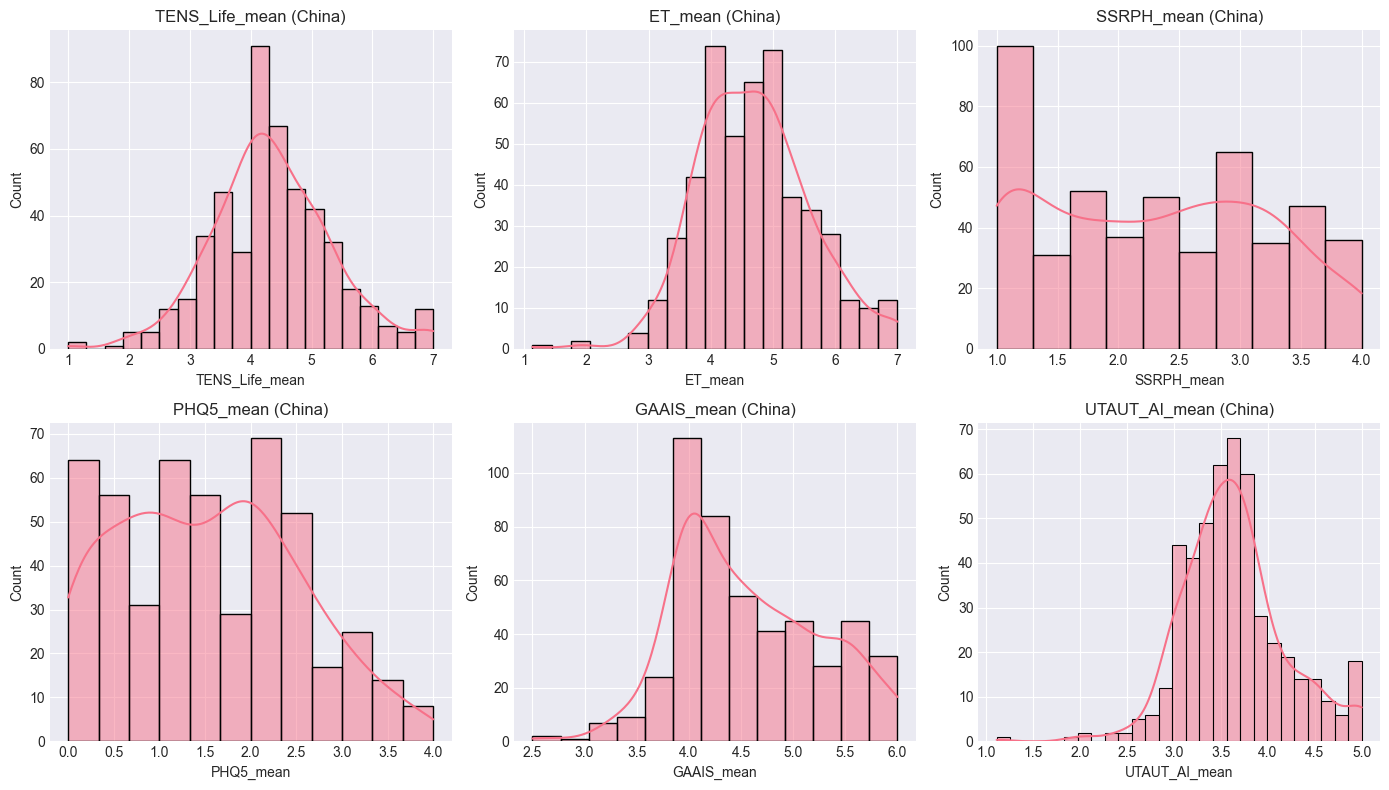

In [106]:
# Distributions of main composites
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()

for ax, comp in zip(axes, key_composites):
    sns.histplot(cn_coalesced[comp], kde=True, ax=ax)
    ax.set_title(f"{comp} (China)")

plt.tight_layout()
plt.show()

In [107]:
# Show key composites
key_composites = [
    'TENS_Life_mean', 'ET_mean', 'SSRPH_mean', 'PHQ5_mean',
    'GAAIS_mean', 'UTAUT_AI_mean',
    'Accept_avatar', 'Accept_chatbot', 'Accept_tele'
]
available_composites = [c for c in key_composites if c in cn_coalesced.columns]
print(f"Key composite scores ({len(available_composites)}):")
for comp in available_composites:
    n_valid = cn_coalesced[comp].notna().sum()
    mean = cn_coalesced[comp].mean()
    print(f"{comp:20} {n_valid:3} valid, M={mean:.2f}")

Key composite scores (9):
TENS_Life_mean       485 valid, M=4.35
ET_mean              485 valid, M=4.70
SSRPH_mean           485 valid, M=2.30
PHQ5_mean            485 valid, M=1.53
GAAIS_mean           485 valid, M=4.57
UTAUT_AI_mean        485 valid, M=3.64
Accept_avatar        485 valid, M=3.67
Accept_chatbot       485 valid, M=3.69
Accept_tele          485 valid, M=3.68


## 2.0. Load and Prepare USA Data

In [108]:
# Load USA data
usa_all = pd.read_csv(USA_DIR / "USA_all.csv", low_memory=False)
print(f"USA_all: {usa_all.shape}")

USA_all: (1857, 624)


### 2.1 Standardize USA Column Names

USA uses different naming conventions. We'll standardize key variables to match China.

In [109]:
# Create mapping dictionary for USA column renaming
usa_renamed = usa_all.copy()

# Rename demographics to match China
rename_map = {}
if 'Age' in usa_renamed.columns and 'age' not in usa_renamed.columns:
    rename_map['Age'] = 'age'
if 'Gender' in usa_renamed.columns and 'gender' not in usa_renamed.columns:
    rename_map['Gender'] = 'gender'
if 'Edu' in usa_renamed.columns and 'edu' not in usa_renamed.columns:
    rename_map['Edu'] = 'edu'

# Rename PHQ_5 to PHQ5
for i in range(1, 6):
    if f"PHQ_5_{i}" in usa_renamed.columns:
        rename_map[f"PHQ_5_{i}"] = f"PHQ5_{i}"
if "PHQ_5_mean" in usa_renamed.columns:
    rename_map["PHQ_5_mean"] = "PHQ5_mean"

# Apply renaming
usa_renamed.rename(columns=rename_map, inplace=True)
print(f"Renamed {len(rename_map)} columns (USA). Examples:", list(rename_map.items())[:5])

Renamed 9 columns (USA). Examples: [('Age', 'age'), ('Gender', 'gender'), ('Edu', 'edu'), ('PHQ_5_1', 'PHQ5_1'), ('PHQ_5_2', 'PHQ5_2')]


### 2.2 Compute Composite Scores for USA

In [110]:
# TENS_Life_mean (needs reverse-coding 1–6; 7–9 as is)
tens_items_usa = [f"TENS_Life_{i}" for i in range(1, 10)]
tens_available_usa = [c for c in tens_items_usa if c in usa_renamed.columns]

usa_reversed = usa_renamed.copy()
for i in range(1, 7):
    col = f"TENS_Life_{i}"
    if col in usa_reversed.columns:
        usa_reversed[f"TENS_Life_{i}r"] = 8 - usa_reversed[col]

for i in range(1, 7):
    rcol = f"TENS_Life_{i}r"
    if rcol in usa_reversed.columns:
        usa_renamed[rcol] = usa_reversed[rcol]

tens_for_mean = [f"TENS_Life_{i}r" for i in range(1, 6 + 1)] + [f"TENS_Life_{i}" for i in range(7, 10)]
tens_for_mean = [c for c in tens_for_mean if c in usa_reversed.columns]
usa_renamed["TENS_Life_mean"] = usa_reversed[tens_for_mean].mean(axis=1)

print(f"TENS_Life_mean: {len(tens_available_usa)} items, Mean={usa_renamed['TENS_Life_mean'].mean():.2f}")

TENS_Life_mean: 9 items, Mean=4.88


In [111]:
# ET_mean
et_items = [f'ET_{i}' for i in range(1, 16)]
et_available = [c for c in et_items if c in usa_renamed.columns]
usa_renamed['ET_mean'] = usa_renamed[et_available].mean(axis=1)
print(f"ET_mean: {len(et_available)}/15 items, Mean={usa_renamed['ET_mean'].mean():.2f}")

ET_mean: 15/15 items, Mean=4.15


In [112]:
# SSRPH_mean
ssrph_items = [f'SSRPH_{i}' for i in range(1, 6)]
ssrph_available = [c for c in ssrph_items if c in usa_renamed.columns]
usa_renamed['SSRPH_mean'] = usa_renamed[ssrph_available].mean(axis=1)
print(f"SSRPH_mean: {len(ssrph_available)}/5 items, Mean={usa_renamed['SSRPH_mean'].mean():.2f}")

SSRPH_mean: 5/5 items, Mean=0.93


In [113]:
# PHQ-5 mean
phq_items = [f'PHQ5_{i}' for i in range(1, 6)]
phq_available = [c for c in phq_items if c in usa_renamed.columns]
usa_renamed['PHQ5_mean'] = usa_renamed[phq_available].mean(axis=1)
print(f"PHQ5_mean: {len(phq_available)}/5 items, Mean={usa_renamed['PHQ5_mean'].mean():.2f}")

PHQ5_mean: 5/5 items, Mean=1.39


In [114]:
# GAAIS_mean
usa_renamed['GAAIS_mean'] = (usa_renamed['GAAIS_pos'] + (8 - usa_renamed['GAAIS_neg'])) / 2
print(f"GAAIS_mean: computed from pos/neg subscales, Mean={usa_renamed['GAAIS_mean'].mean():.2f}")

GAAIS_mean: computed from pos/neg subscales, Mean=4.62


In [115]:
# UTAUT - USA has different structure (UTAUT_1_X, UTAUT_2_X, UTAUT_3_X)
# We'll average across all UTAUT items for simplicity
utaut_cols = [c for c in usa_renamed.columns if c.startswith('UTAUT_') and '_' in c[6:]]
# Filter out validation columns
utaut_cols = [c for c in utaut_cols if 'validation' not in c.lower()]
usa_renamed['UTAUT_AI_mean'] = usa_renamed[utaut_cols].mean(axis=1)
print(f"UTAUT_AI_mean: {len(utaut_cols)} items, Mean={usa_renamed['UTAUT_AI_mean'].mean():.2f}")

UTAUT_AI_mean: 86 items, Mean=5.10


### 2.2.1. Intervention-Specific Acceptance (USA)

In [116]:
avatar_cols_usa  = [c for c in usa_renamed.columns if c.startswith("UTAUT_1_")]
chatbot_cols_usa = [c for c in usa_renamed.columns if c.startswith("UTAUT_2_")]
human_cols_usa   = [c for c in usa_renamed.columns if c.startswith("UTAUT_3_")]

if avatar_cols_usa:
    usa_renamed["Accept_avatar"] = usa_renamed[avatar_cols_usa].mean(axis=1)
    print(f"Accept_avatar (USA): k={len(avatar_cols_usa)}, M={usa_renamed['Accept_avatar'].mean():.2f}")

if chatbot_cols_usa:
    usa_renamed["Accept_chatbot"] = usa_renamed[chatbot_cols_usa].mean(axis=1)
    print(f"Accept_chatbot (USA): k={len(chatbot_cols_usa)}, M={usa_renamed['Accept_chatbot'].mean():.2f}")

if human_cols_usa:
    usa_renamed["Accept_tele"] = usa_renamed[human_cols_usa].mean(axis=1)
    print(f"Accept_tele (USA): k={len(human_cols_usa)}, M={usa_renamed['Accept_tele'].mean():.2f}")

Accept_avatar (USA): k=11, M=3.72
Accept_chatbot (USA): k=11, M=3.71
Accept_tele (USA): k=11, M=2.42


### Important Note on UTAUT Measurement

> [!WARNING]
> **Measurement Differences Across Countries:**
> - **China:** Uses a 26-item UTAUT_AI scale designed for AI acceptance in mental health
> - **USA:** Uses an 86-item composite UTAUT measure (includes multiple versions: AIavatar, etc.)
> - Both are treated as "AI Acceptance" (`UTAUT_AI_mean`) but represent **different instruments**
> - This measurement difference should be considered when interpreting cross-cultural comparisons
> - Subscale analyses may vary in validity across countries due to different item pools

### 2.3 Add Country Label for USA

In [117]:
# Add Country column
usa_renamed['Country'] = 'USA'

print("USA DATA COMPLETE")
print(f"Shape: {usa_renamed.shape}")
print(f"Participants: {len(usa_renamed)}")
print(f"Variables: {len(usa_renamed.columns)}")

USA DATA COMPLETE
Shape: (1857, 639)
Participants: 1857
Variables: 639


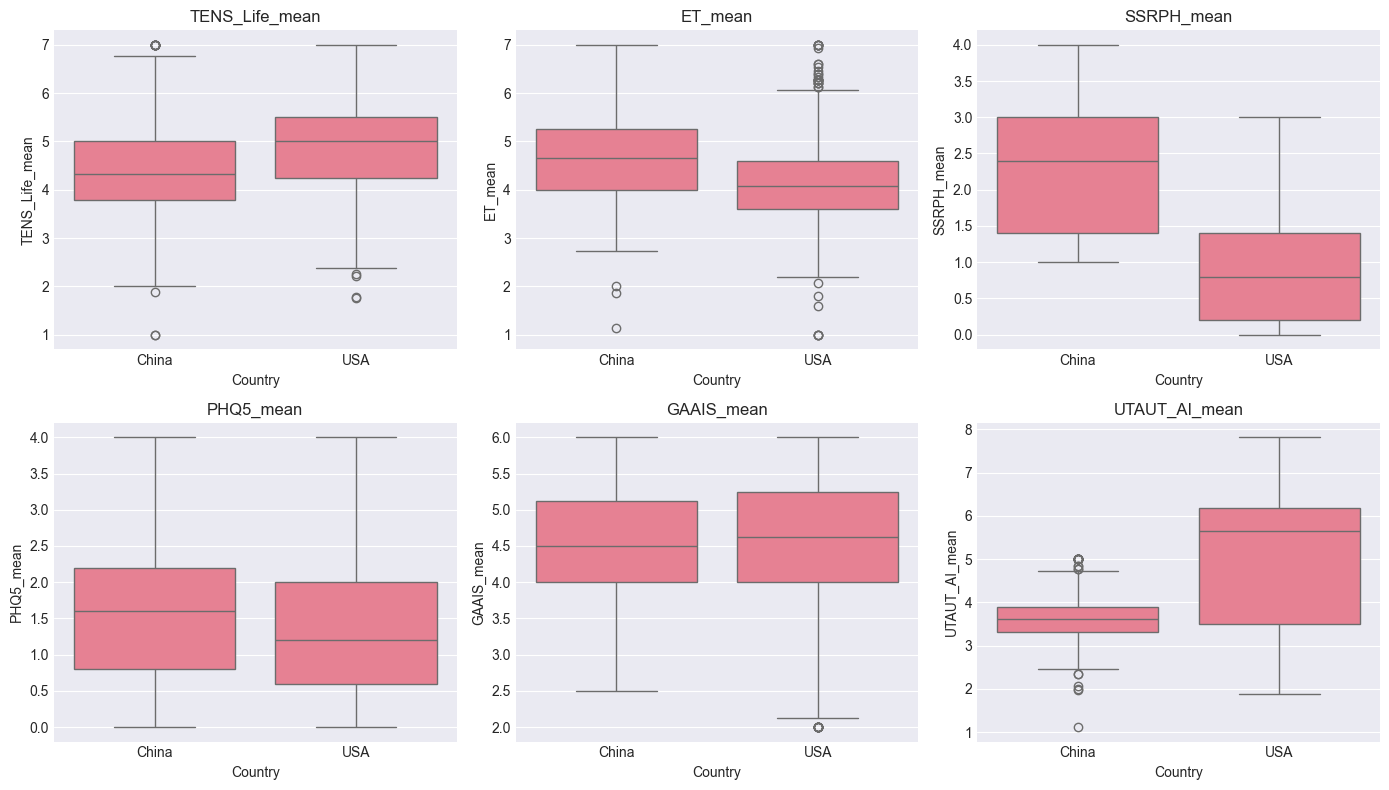

In [118]:
# Stack both just for visual comparison
tmp = pd.concat([
    cn_coalesced[["Country"] + key_composites],
    usa_renamed[["Country"] + key_composites]
], ignore_index=True)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()

for ax, comp in zip(axes, key_composites):
    sns.boxplot(data=tmp, x="Country", y=comp, ax=ax)
    ax.set_title(comp)

plt.tight_layout()
plt.show()

In [119]:
# Show key composites
available_composites = [c for c in key_composites if c in usa_renamed.columns]
print(f"Key composite scores ({len(available_composites)}):")
for comp in available_composites:
    n_valid = usa_renamed[comp].notna().sum()
    mean = usa_renamed[comp].mean()
    print(f"{comp:20} {n_valid:4} valid, M={mean:.2f}")

Key composite scores (9):
TENS_Life_mean       1618 valid, M=4.88
ET_mean              1620 valid, M=4.15
SSRPH_mean           1607 valid, M=0.93
PHQ5_mean            1621 valid, M=1.39
GAAIS_mean           1726 valid, M=4.62
UTAUT_AI_mean        1677 valid, M=5.10
Accept_avatar        1677 valid, M=3.72
Accept_chatbot       1665 valid, M=3.71
Accept_tele          1677 valid, M=2.42


## 2.4. Add role label for USA 

In [120]:
usa_renamed["role_label"] = "unknown"

# EXAMPLE – replace these conditions with your actual codebook
# e.g., if 'mh_service' or a dedicated 'role' variable exists:
if "role" in usa_renamed.columns:
    usa_renamed.loc[usa_renamed["role"] == 1, "role_label"] = "client"
    usa_renamed.loc[usa_renamed["role"] == 2, "role_label"] = "therapist"

print("USA role_label distribution:")
print(usa_renamed["role_label"].value_counts())

USA role_label distribution:
role_label
unknown    1857
Name: count, dtype: int64


## 3.0. Merge USA and China Data

Create a single merged dataset with columns that exist in both countries.

In [121]:
# Find common columns
cn_cols = set(cn_coalesced.columns)
usa_cols = set(usa_renamed.columns)
common_cols = sorted(list(cn_cols & usa_cols))

print(f"Common columns: {len(common_cols)}")
print(f"China-only columns: {len(cn_cols - usa_cols)}")
print(f"USA-only columns: {len(usa_cols - cn_cols)}")

Common columns: 273
China-only columns: 431
USA-only columns: 367


In [122]:
# Ensure key variables are in common columns
key_vars = ['Country', 'age', 'gender', 'edu', 
            'TENS_Life_mean', 'ET_mean', 'SSRPH_mean', 
            'PHQ5_mean', 'GAAIS_mean', 'UTAUT_AI_mean',
            'GAAIS_pos', 'GAAIS_neg']

key_vars_available = [v for v in key_vars if v in common_cols]

print(f"Key variables in common: {len(key_vars_available)}/{len(key_vars)}")
print(f"Available: {key_vars_available}")

Key variables in common: 12/12
Available: ['Country', 'age', 'gender', 'edu', 'TENS_Life_mean', 'ET_mean', 'SSRPH_mean', 'PHQ5_mean', 'GAAIS_mean', 'UTAUT_AI_mean', 'GAAIS_pos', 'GAAIS_neg']


### 3.1. Full merged dataset with common and selected extra variables

In [123]:
merge_cols = sorted(list(set(common_cols) | set([v for v in key_vars if v in cn_cols or v in usa_cols])))

cn_subset = cn_coalesced.reindex(columns=merge_cols)
usa_subset = usa_renamed.reindex(columns=merge_cols)

merged = pd.concat([cn_subset, usa_subset], ignore_index=True)
print(f"Merged: {merged.shape}")

Merged: (2342, 273)


In [124]:
print(f"Country distribution:")
print(merged['Country'].value_counts().to_string())

Country distribution:
Country
USA      1857
China     485


### 3.2. Union with suffixes

In [125]:
cn_union = cn_coalesced.rename(columns={c: f"{c}_CN" for c in cn_only})
usa_union = usa_renamed.rename(columns={c: f"{c}_USA" for c in usa_only})

all_cols_union = sorted(list(set(cn_union.columns) | set(usa_union.columns)))
cn_union = cn_union.reindex(columns=all_cols_union)
usa_union = usa_union.reindex(columns=all_cols_union)

union_with_suffix = pd.concat([cn_union, usa_union], ignore_index=True)
print(f"Union: {union_with_suffix.shape}")

NameError: name 'cn_only' is not defined

### 3.3. Export Merged Dataset

In [126]:
# Save outputs
merged_path = MERGED_DIR / "merged.csv"
union_path = MERGED_DIR / "union_with_suffix.csv"

merged.to_csv(merged_path, index=False)
union_with_suffix.to_csv(union_path, index=False)

print("Saved:")
print(" -", merged_path)
print(" -", intersection_path)
print(" -", union_path)

NameError: name 'union_with_suffix' is not defined

### 3.4. Summary Statistics

In [127]:
dataset_summary = pd.DataFrame({
    "Dataset": [
        "China", "USA",
        "Union", "Merged"
    ],
    "Rows": [
        cn_coalesced.shape[0],
        usa_renamed.shape[0],
        union_with_suffix.shape[0],
        merged.shape[0]
    ],
    "Columns": [
        cn_coalesced.shape[1],
        usa_renamed.shape[1],
        union_with_suffix.shape[1],
        merged.shape[1]
    ]
})
print(dataset_summary)

NameError: name 'union_with_suffix' is not defined

In [128]:
# Show summary of key variables
print(f"Key composite scores summary:")
key_composites = [
    'TENS_Life_mean', 'ET_mean', 'SSRPH_mean', 'PHQ5_mean',
    'GAAIS_mean', 'UTAUT_AI_mean',
    'Accept_avatar', 'Accept_chatbot', 'Accept_tele'
]
for comp in key_composites:
    if comp in merged.columns:
        total_valid = merged[comp].notna().sum()
        total = len(merged)
        pct = total_valid / total * 100
        mean = merged[comp].mean()
        print(f"{comp:20} {total_valid:4}/{total} ({pct:5.1f}%) valid, M={mean:.2f}")

Key composite scores summary:
TENS_Life_mean       2103/2342 ( 89.8%) valid, M=4.76
ET_mean              2105/2342 ( 89.9%) valid, M=4.27
SSRPH_mean           2092/2342 ( 89.3%) valid, M=1.25
PHQ5_mean            2106/2342 ( 89.9%) valid, M=1.42
GAAIS_mean           2211/2342 ( 94.4%) valid, M=4.61
UTAUT_AI_mean        2162/2342 ( 92.3%) valid, M=4.78
Accept_avatar        2162/2342 ( 92.3%) valid, M=3.71
Accept_chatbot       2150/2342 ( 91.8%) valid, M=3.70
Accept_tele          2162/2342 ( 92.3%) valid, M=2.71


NameError: name 'dataset_summary' is not defined

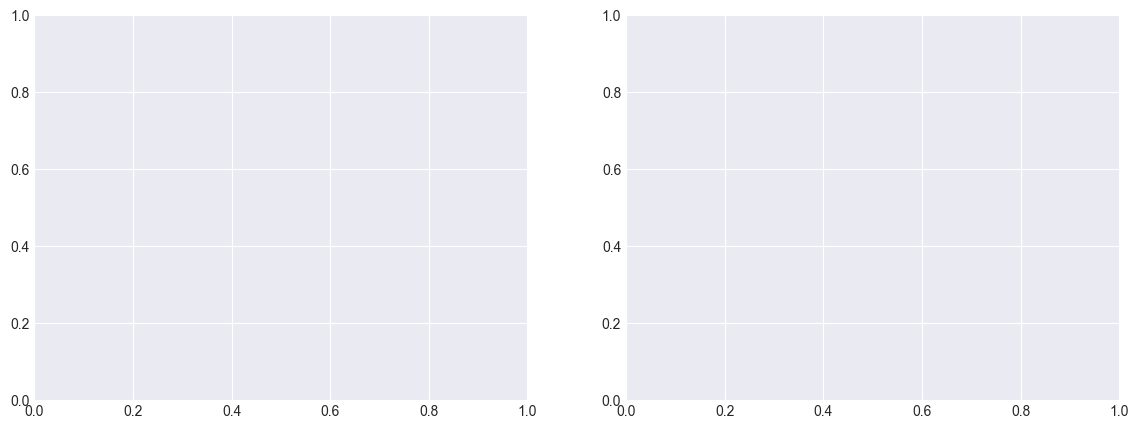

In [129]:
# Visualize dataset sizes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(len(dataset_summary)), dataset_summary['Rows'])
axes[0].set_xticks(range(len(dataset_summary)))
axes[0].set_xticklabels(dataset_summary['Dataset'], rotation=45, ha='right')
axes[0].set_ylabel('Number of Rows')
axes[0].set_title('Dataset Sizes (Participants)')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(range(len(dataset_summary)), dataset_summary['Columns'])
axes[1].set_xticks(range(len(dataset_summary)))
axes[1].set_xticklabels(dataset_summary['Dataset'], rotation=45, ha='right')
axes[1].set_ylabel('Number of Columns')
axes[1].set_title('Dataset Widths (Variables)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("Key observations:")
print(f"Union has maximum columns ({union_with_suffix.shape[1]}) - all variables with suffixes")
print(f"Merged Full has {merged.shape[1]} columns - balanced for analysis")

Key observations:


NameError: name 'union_with_suffix' is not defined

## 4.0. Data Quality Summary

In [130]:
# Define key composite scores
key_composites = ['TENS_Life_mean', 'ET_mean', 'SSRPH_mean', 'PHQ5_mean', 'GAAIS_mean', 'UTAUT_AI_mean']

print("DATA QUALITY SUMMARY BY COUNTRY")
for country in ['China', 'USA']:
    df_country = merged[merged['Country'] == country]
    print(f"{country} (N={len(df_country)})")
    for comp in key_composites:
        if comp in df_country.columns:
            n_valid = df_country[comp].notna().sum()
            mean = df_country[comp].mean()
            std = df_country[comp].std()
            print(f"{comp:20} N={n_valid:4}, M={mean:.2f}, SD={std:.2f}")

DATA QUALITY SUMMARY BY COUNTRY
China (N=485)
TENS_Life_mean       N= 485, M=4.35, SD=0.99
ET_mean              N= 485, M=4.70, SD=0.91
SSRPH_mean           N= 485, M=2.30, SD=0.93
PHQ5_mean            N= 485, M=1.53, SD=0.99
GAAIS_mean           N= 485, M=4.57, SD=0.69
UTAUT_AI_mean        N= 485, M=3.64, SD=0.55
USA (N=1857)
TENS_Life_mean       N=1618, M=4.88, SD=1.00
ET_mean              N=1620, M=4.15, SD=0.80
SSRPH_mean           N=1607, M=0.93, SD=0.76
PHQ5_mean            N=1621, M=1.39, SD=1.05
GAAIS_mean           N=1726, M=4.62, SD=0.82
UTAUT_AI_mean        N=1677, M=5.10, SD=1.38


### 4.1. Reliability Analysis (Cronbach's Alpha)

Compute internal consistency reliability for all scales by country

In [131]:
def cronbach_alpha(df, cols):

    items = df[cols].dropna()
    if len(items) == 0:
        return np.nan
    
    k = items.shape[1]
    if k < 2:
        return np.nan
    
    # Variance of each item
    item_var = items.var(axis=0, ddof=1).sum()
    
    # Variance of total score
    total_var = items.sum(axis=1).var(ddof=1)
    
    if total_var == 0:
        return np.nan
    
    alpha = (k / (k - 1)) * (1 - item_var / total_var)
    return alpha

In [132]:
# Ensure GAAIS_neg_rev exists in both country-level dataframes
for df_ in [cn_coalesced, usa_renamed]:
    if 'GAAIS_neg' in df_.columns:
        df_['GAAIS_neg_rev'] = 8 - df_['GAAIS_neg']

# Define full scale item sets
scale_items_country = {
    "TENS_Life": ['TENS_Life_1r', 'TENS_Life_2r', 'TENS_Life_3r', 'TENS_Life_4r',
                  'TENS_Life_5r', 'TENS_Life_6r', 'TENS_Life_7', 'TENS_Life_8', 'TENS_Life_9'],
    "ET":        [f'ET_{i}' for i in range(1, 16)],
    "SSRPH":     [f'SSRPH_{i}' for i in range(1, 6)],
    "PHQ5":      [f'PHQ5_{i}' for i in range(1, 6)],
    "GAAIS_overall": ['GAAIS_pos', 'GAAIS_neg_rev'],
}

In [133]:
print("CRONBACH'S ALPHA (FULL SCALES) BY COUNTRY")
print("=" * 60)

for country_name, df_country in [("China", cn_coalesced), ("USA", usa_renamed)]:
    print(f"{country_name}:")
    print("-" * 60)
    for scale_name, items in scale_items_country.items():
        available_items = [col for col in items if col in df_country.columns]
        if len(available_items) >= 2:
            alpha = cronbach_alpha(df_country, available_items)
            n_items = len(available_items)
            n_valid = df_country[available_items].dropna().shape[0]
            print(f"{scale_name:15} α = {alpha:.3f}  (k={n_items:2}, n={n_valid:4})")
        else:
            print(f"{scale_name:15} α = N/A (only {len(available_items)} item(s) present)")
    print()

CRONBACH'S ALPHA (FULL SCALES) BY COUNTRY
China:
------------------------------------------------------------
TENS_Life       α = 0.823  (k= 9, n= 485)
ET              α = 0.877  (k=15, n= 485)
SSRPH           α = 0.892  (k= 5, n= 485)
PHQ5            α = 0.881  (k= 5, n= 485)
GAAIS_overall   α = 0.059  (k= 2, n= 485)

USA:
------------------------------------------------------------
TENS_Life       α = 0.629  (k= 9, n= 507)
ET              α = 0.781  (k=15, n=1620)
SSRPH           α = 0.859  (k= 5, n=1607)
PHQ5            α = 0.890  (k= 5, n=1621)
GAAIS_overall   α = 0.661  (k= 2, n=1726)



## 5.0. Complete Cases for Hypotheses

In [134]:
print("COMPLETE CASES FOR HYPOTHESES")

hypothesis_vars = {
    "H1: SDT to AI Acceptance": ["TENS_Life_mean", "UTAUT_AI_mean", "age", "gender"],
    "H2: AI Attitude Moderation": ["TENS_Life_mean", "UTAUT_AI_mean", "GAAIS_mean", "age", "gender"],
    "H3: Cross-Cultural": ["TENS_Life_mean", "UTAUT_AI_mean", "Country", "age", "gender"],
    "H4: ET Mediation": ["TENS_Life_mean", "ET_mean", "UTAUT_AI_mean", "age", "gender", "Country"],
}

for hyp, vars_list in hypothesis_vars.items():
    avail = [v for v in vars_list if v in merged.columns]
    complete = merged[avail].dropna()
    print(f"\n{hyp}")
    print(f"Variables: {', '.join(avail)}")
    print(f"Complete cases: {len(complete):4} / {len(merged)} ({len(complete)/len(merged)*100:.1f}%)")
    if "Country" in complete.columns:
        for country in ["China", "USA"]:
            n_c = len(complete[complete["Country"] == country])
            print(f"  {country}: {n_c}")

COMPLETE CASES FOR HYPOTHESES

H1: SDT to AI Acceptance
Variables: TENS_Life_mean, UTAUT_AI_mean, age, gender
Complete cases: 2096 / 2342 (89.5%)

H2: AI Attitude Moderation
Variables: TENS_Life_mean, UTAUT_AI_mean, GAAIS_mean, age, gender
Complete cases: 2096 / 2342 (89.5%)

H3: Cross-Cultural
Variables: TENS_Life_mean, UTAUT_AI_mean, Country, age, gender
Complete cases: 2096 / 2342 (89.5%)
  China: 485
  USA: 1611

H4: ET Mediation
Variables: TENS_Life_mean, ET_mean, UTAUT_AI_mean, age, gender, Country
Complete cases: 2096 / 2342 (89.5%)
  China: 485
  USA: 1611


### 5.1. Missing Data Imputation

Use IterativeImputer to handle missing data in key hypothesis variables

In [135]:
# Key variables for hypothesis testing
h_vars = [
    'TENS_Life_mean', 'UTAUT_AI_mean', 'GAAIS_mean',
    'ET_mean', 'PHQ5_mean', 'SSRPH_mean', 'age'
]

print("Missing data summary before imputation:")
print("-" * 50)
for var in h_vars:
    if var in merged.columns:
        n_missing = merged[var].isna().sum()
        pct_missing = (n_missing / len(merged)) * 100
        print(f"{var:20} {n_missing:4} missing ({pct_missing:5.1f}%)")


Missing data summary before imputation:
--------------------------------------------------
TENS_Life_mean        239 missing ( 10.2%)
UTAUT_AI_mean         180 missing (  7.7%)
GAAIS_mean            131 missing (  5.6%)
ET_mean               237 missing ( 10.1%)
PHQ5_mean             236 missing ( 10.1%)
SSRPH_mean            250 missing ( 10.7%)
age                   115 missing (  4.9%)


In [136]:
complete_before = merged[h_vars].dropna()
print(f"Complete cases (listwise deletion across all h_vars): "
      f"{len(complete_before)} / {len(merged)} ({len(complete_before)/len(merged)*100:.1f}%)")

Complete cases (listwise deletion across all h_vars): 2085 / 2342 (89.0%)


### 5.2. One-hot Encode

In [137]:
# Need to encode categorical variables (gender, Country)
impute_vars = h_vars + ['gender', 'Country']
impute_df = merged[impute_vars].copy()

# One-hot encode categoricals
impute_df_encoded = pd.get_dummies(impute_df, columns=['gender', 'Country'], drop_first=True)

print(f"Imputation dataset shape: {impute_df_encoded.shape}")
print(f"Variables: {list(impute_df_encoded.columns)}")

Imputation dataset shape: (2342, 11)
Variables: ['TENS_Life_mean', 'UTAUT_AI_mean', 'GAAIS_mean', 'ET_mean', 'PHQ5_mean', 'SSRPH_mean', 'age', 'gender_2.0', 'gender_3.0', 'gender_4.0', 'Country_USA']


### 5.3. Imputation process

In [138]:
# Initialize imputer
imputer = IterativeImputer(random_state=42, max_iter=10)
imputed_array = imputer.fit_transform(impute_df_encoded)

# Convert back to DataFrame
merged_imputed = pd.DataFrame(imputed_array, columns=impute_df_encoded.columns, index=merged.index)

# Decode gender and Country back from dummy variables and keep the continuous variables
for var in h_vars:
    merged[f'{var}_imputed'] = merged_imputed[var]

print("Imputation complete.")
print(f"Imputed variables created: {[f'{v}_imputed' for v in h_vars]}")

Imputation complete.
Imputed variables created: ['TENS_Life_mean_imputed', 'UTAUT_AI_mean_imputed', 'GAAIS_mean_imputed', 'ET_mean_imputed', 'PHQ5_mean_imputed', 'SSRPH_mean_imputed', 'age_imputed']


### 5.4. Compare distributions before and after imputation

In [139]:
# Compare distributions before/after imputation
print("Comparison of means before/after imputation:")
print("=" * 60)
print(f"{'Variable':20} {'Original':>12} {'Imputed':>12} {'Diff':>10}")
print("-" * 60)

for var in h_vars:
    if var in merged.columns:
        orig_mean = merged[var].mean()
        imp_mean = merged[f'{var}_imputed'].mean()
        diff = imp_mean - orig_mean
        print(f"{var:20} {orig_mean:12.3f} {imp_mean:12.3f} {diff:10.3f}")

Comparison of means before/after imputation:
Variable                 Original      Imputed       Diff
------------------------------------------------------------
TENS_Life_mean              4.759        4.775      0.016
UTAUT_AI_mean               4.776        4.797      0.021
GAAIS_mean                  4.611        4.608     -0.003
ET_mean                     4.273        4.253     -0.020
PHQ5_mean                   1.422        1.414     -0.008
SSRPH_mean                  1.246        1.208     -0.038
age                        34.159       34.464      0.306


#### Robustness Check Option

To run hypothesis tests with imputed data (robustness check), replace variable names in H1-H4:
- `TENS_Life_mean` → `TENS_Life_mean_imputed`
- `UTAUT_AI_mean` → `UTAUT_AI_mean_imputed`
- `GAAIS_mean` → `GAAIS_mean_imputed`
- `ET_mean` → `ET_mean_imputed`
- etc.

The current analyses use **complete-case** (non-imputed) data.

## 6.0. Hypothesis Testing

In [140]:
df = merged.copy()

print("Columns available for hypotheses:")
print([c for c in df.columns if c in [
    "TENS_Life_mean", "UTAUT_AI_mean", "GAAIS_mean", "ET_mean",
    "PHQ5_mean", "SSRPH_mean", "age", "gender", "Country", "role_label",
    "Accept_avatar", "Accept_chatbot", "Accept_tele"
]])

# Center continuous predictors (used where needed)
for col in ["TENS_Life_mean", "GAAIS_mean", "ET_mean", "age"]:
    if col in df.columns:
        df[col + "_c"] = df[col] - df[col].mean()

print("Centered variables created:", [c for c in df.columns if c.endswith("_c")])

Columns available for hypotheses:
['Accept_avatar', 'Accept_chatbot', 'Accept_tele', 'Country', 'ET_mean', 'GAAIS_mean', 'PHQ5_mean', 'SSRPH_mean', 'TENS_Life_mean', 'UTAUT_AI_mean', 'age', 'gender', 'role_label']
Centered variables created: ['TENS_Life_mean_c', 'GAAIS_mean_c', 'ET_mean_c', 'age_c']


In [141]:
# --------------------------------------------
# H1 — Main Effect: SDT → AI Acceptance
# --------------------------------------------

h1_vars = ["TENS_Life_mean", "UTAUT_AI_mean", "age", "gender"]
h1_df = df[h1_vars].dropna().copy()
print(f"\nH1 sample size (listwise): N = {len(h1_df)}")

r, p = stats.pearsonr(h1_df["TENS_Life_mean"], h1_df["UTAUT_AI_mean"])
print(f"Pearson r(TENS_Life_mean, UTAUT_AI_mean) = {r:.3f}, p = {p:.4g}")

h1_model = smf.ols(
    formula="UTAUT_AI_mean ~ TENS_Life_mean + age + C(gender)",
    data=h1_df
).fit()

print("\nH1 Regression Summary: UTAUT_AI_mean ~ TENS_Life_mean + age + C(gender)")
print(h1_model.summary())


H1 sample size (listwise): N = 2096
Pearson r(TENS_Life_mean, UTAUT_AI_mean) = 0.160, p = 1.947e-13

H1 Regression Summary: UTAUT_AI_mean ~ TENS_Life_mean + age + C(gender)
                            OLS Regression Results                            
Dep. Variable:          UTAUT_AI_mean   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     21.80
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           2.45e-21
Time:                        15:44:20   Log-Likelihood:                -3600.9
No. Observations:                2096   AIC:                             7214.
Df Residuals:                    2090   BIC:                             7248.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std e

In [142]:
# --------------------------------------------
# H2 — Attitudinal Moderation: TENS × GAAIS
# --------------------------------------------

h2_vars = ["UTAUT_AI_mean",
           "TENS_Life_mean_c", "GAAIS_mean_c",
           "age_c", "gender", "Country"]

# Ensure age_c exists
if "age_c" not in df.columns and "age" in df.columns:
    df["age_c"] = df["age"] - df["age"].mean()

h2_df = df[h2_vars].dropna().copy()
print(f"\nH2 sample size (listwise): N = {len(h2_df)}")

h2_model = smf.ols(
    formula=("UTAUT_AI_mean ~ "
             "TENS_Life_mean_c * GAAIS_mean_c "
             "+ age_c + C(gender) + C(Country)"),
    data=h2_df
).fit()

print("\nH2 Moderation Regression Summary:")
print("Model: UTAUT_AI_mean ~ TENS_Life_mean_c * GAAIS_mean_c + age_c + C(gender) + C(Country)")
print(h2_model.summary())


H2 sample size (listwise): N = 2096

H2 Moderation Regression Summary:
Model: UTAUT_AI_mean ~ TENS_Life_mean_c * GAAIS_mean_c + age_c + C(gender) + C(Country)
                            OLS Regression Results                            
Dep. Variable:          UTAUT_AI_mean   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     97.21
Date:                Sat, 29 Nov 2025   Prob (F-statistic):          1.13e-137
Time:                        15:44:20   Log-Likelihood:                -3322.3
No. Observations:                2096   AIC:                             6663.
Df Residuals:                    2087   BIC:                             6713.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std er

In [143]:
# --------------------------------------------
# H3 — Cross-Cultural Moderation: TENS × Country
# --------------------------------------------

h3_vars = ["UTAUT_AI_mean",
           "TENS_Life_mean_c",
           "age_c", "gender", "Country"]

h3_df = df[h3_vars].dropna().copy()
print(f"\nH3 sample size (listwise): N = {len(h3_df)}")
print("\nH3 Country breakdown:")
print(h3_df["Country"].value_counts())

h3_model = smf.ols(
    formula=("UTAUT_AI_mean ~ "
             "TENS_Life_mean_c * C(Country) "
             "+ age_c + C(gender)"),
    data=h3_df
).fit()

print("\nH3 Cross-Cultural Moderation Summary:")
print("Model: UTAUT_AI_mean ~ TENS_Life_mean_c * C(Country) + age_c + C(gender)")
print(h3_model.summary())


H3 sample size (listwise): N = 2096

H3 Country breakdown:
Country
USA      1611
China     485
Name: count, dtype: int64

H3 Cross-Cultural Moderation Summary:
Model: UTAUT_AI_mean ~ TENS_Life_mean_c * C(Country) + age_c + C(gender)
                            OLS Regression Results                            
Dep. Variable:          UTAUT_AI_mean   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     105.5
Date:                Sat, 29 Nov 2025   Prob (F-statistic):          1.71e-132
Time:                        15:44:20   Log-Likelihood:                -3336.7
No. Observations:                2096   AIC:                             6689.
Df Residuals:                    2088   BIC:                             6735.
Df Model:                           7                                         
Covariance Type:            nonrobust                  

In [144]:
# --------------------------------------------
# H4 — Mediation: TENS → ET → AI Acceptance
# --------------------------------------------

# Ensure ET_mean_c exists
if "ET_mean_c" not in df.columns and "ET_mean" in df.columns:
    df["ET_mean_c"] = df["ET_mean"] - df["ET_mean"].mean()

h4_vars = ["TENS_Life_mean_c", "ET_mean_c",
           "UTAUT_AI_mean", "age_c", "gender", "Country"]

h4_df = df[h4_vars].dropna().copy()
print(f"\nH4 sample size (listwise): N = {len(h4_df)}")

# Path a: TENS → ET
a_model = smf.ols(
    formula="ET_mean_c ~ TENS_Life_mean_c + age_c + C(gender) + C(Country)",
    data=h4_df
).fit()
print("\nH4 Path a (TENS_Life_mean_c → ET_mean_c):")
print(a_model.summary().tables[1])

# Path b + c': ET + TENS → UTAUT
b_model = smf.ols(
    formula="UTAUT_AI_mean ~ TENS_Life_mean_c + ET_mean_c + age_c + C(gender) + C(Country)",
    data=h4_df
).fit()
print("\nH4 Path b + c' (ET_mean_c and TENS_Life_mean_c → UTAUT_AI_mean):")
print(b_model.summary().tables[1])

a_coef = a_model.params["TENS_Life_mean_c"]
b_coef = b_model.params["ET_mean_c"]
print(f"\nPoint estimate of indirect effect (a * b) = {a_coef * b_coef:.4f}")

# Bootstrap CI for indirect effect
n_boot = 5000
boot_indirect = []
n = len(h4_df)

for _ in range(n_boot):
    sample_idx = np.random.choice(n, size=n, replace=True)
    sample = h4_df.iloc[sample_idx]

    a_m = smf.ols(
        formula="ET_mean_c ~ TENS_Life_mean_c + age_c + C(gender) + C(Country)",
        data=sample
    ).fit()

    b_m = smf.ols(
        formula="UTAUT_AI_mean ~ TENS_Life_mean_c + ET_mean_c + age_c + C(gender) + C(Country)",
        data=sample
    ).fit()

    a_b = a_m.params.get("TENS_Life_mean_c", np.nan)
    b_b = b_m.params.get("ET_mean_c", np.nan)
    if not np.isnan(a_b) and not np.isnan(b_b):
        boot_indirect.append(a_b * b_b)

boot_indirect = np.array(boot_indirect)
indirect_mean = np.mean(boot_indirect)
ci_lower, ci_upper = np.percentile(boot_indirect, [2.5, 97.5])

print(f"\nBootstrapped indirect effect (a*b): mean = {indirect_mean:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Number of successful bootstrap samples: {len(boot_indirect)} / {n_boot}")


H4 sample size (listwise): N = 2096

H4 Path a (TENS_Life_mean_c → ET_mean_c):
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1896      0.052      3.632      0.000       0.087       0.292
C(gender)[T.2.0]      0.0599      0.037      1.633      0.103      -0.012       0.132
C(gender)[T.3.0]      0.0340      0.126      0.269      0.788      -0.214       0.282
C(gender)[T.4.0]     -0.3645      0.311     -1.174      0.241      -0.974       0.245
C(Country)[T.USA]    -0.2864      0.059     -4.870      0.000      -0.402      -0.171
TENS_Life_mean_c     -0.0549      0.018     -3.031      0.002      -0.090      -0.019
age_c                -0.0083      0.001     -5.692      0.000      -0.011      -0.005

H4 Path b + c' (ET_mean_c and TENS_Life_mean_c → UTAUT_AI_mean):
                        coef    std err          t      P>|t|      [0.025      0

### 6.1. Baseline Acceptance Models by Intervention

In [145]:
baseline_outcomes = ["Accept_avatar", "Accept_chatbot", "Accept_tele"]

for outcome in baseline_outcomes:
    cols = [outcome, "age", "gender", "PHQ5_mean", "SSRPH_mean",
            "GAAIS_mean", "ET_mean", "Country", "role_label"]
    b_df = df[cols].dropna().copy()

    if b_df.empty:
        print(f"\nBaseline model for {outcome}: no complete cases.")
        continue

    b_df["age_c"] = b_df["age"] - b_df["age"].mean()

    print(f"\nBaseline model for {outcome} (N={len(b_df)})")

    formula = (
        f"{outcome} ~ age_c + C(gender) "
        "+ PHQ5_mean + SSRPH_mean + GAAIS_mean + ET_mean "
        "+ C(Country) + C(role_label)"
    )

    baseline_model = smf.ols(formula=formula, data=b_df).fit()
    print(baseline_model.summary().tables[1])


Baseline model for Accept_avatar (N=2085)
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      4.6467      0.141     32.854      0.000       4.369       4.924
C(gender)[T.2.0]              -0.2148      0.033     -6.575      0.000      -0.279      -0.151
C(gender)[T.3.0]              -0.0253      0.111     -0.227      0.820      -0.244       0.193
C(gender)[T.4.0]               0.3778      0.273      1.384      0.167      -0.158       0.913
C(Country)[T.USA]              0.0992      0.034      2.882      0.004       0.032       0.167
C(role_label)[T.therapist]     0.0768      0.066      1.167      0.243      -0.052       0.206
C(role_label)[T.unknown]       0.0992      0.034      2.882      0.004       0.032       0.167
age_c                         -0.0047      0.001     -3.574      0.000      -0.007      -0.002
PHQ5_me

### 6.2. H1 – Main Effect of SDT on Intervention-Specific Acceptance

In [146]:
print("\n=== H1: SDT → Acceptance per Intervention ===")

h1_outcomes = ["Accept_avatar", "Accept_chatbot", "Accept_tele", "UTAUT_AI_mean"]

for outcome in h1_outcomes:
    cols = [outcome, "TENS_Life_mean", "age", "gender",
            "PHQ5_mean", "SSRPH_mean", "GAAIS_mean", "ET_mean",
            "Country", "role_label"]
    h1_df = df[cols].dropna().copy()

    if h1_df.empty:
        print(f"\nH1 model for {outcome}: no complete cases.")
        continue

    h1_df["TENS_Life_mean_c"] = h1_df["TENS_Life_mean"] - h1_df["TENS_Life_mean"].mean()
    h1_df["age_c"] = h1_df["age"] - h1_df["age"].mean()

    print(f"\nH1 model for {outcome} (N={len(h1_df)})")
    formula = (
        f"{outcome} ~ TENS_Life_mean_c "
        "+ age_c + C(gender) "
        "+ PHQ5_mean + SSRPH_mean + GAAIS_mean + ET_mean "
        "+ C(Country) + C(role_label)"
    )
    h1_model = smf.ols(formula=formula, data=h1_df).fit()
    print(h1_model.summary().tables[1])



=== H1: SDT → Acceptance per Intervention ===

H1 model for Accept_avatar (N=2085)
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      4.6508      0.143     32.590      0.000       4.371       4.931
C(gender)[T.2.0]              -0.2139      0.033     -6.496      0.000      -0.279      -0.149
C(gender)[T.3.0]              -0.0255      0.112     -0.229      0.819      -0.244       0.193
C(gender)[T.4.0]               0.3767      0.273      1.379      0.168      -0.159       0.912
C(Country)[T.USA]              0.0985      0.035      2.847      0.004       0.031       0.166
C(role_label)[T.therapist]     0.0758      0.066      1.149      0.251      -0.054       0.205
C(role_label)[T.unknown]       0.0985      0.035      2.847      0.004       0.031       0.166
TENS_Life_mean_c               0.0036      0.017      0.218  

### 6.3. H3a – Cultural Moderation (TENS × Country)

In [147]:
print("\n=== H3a: SDT × Country per Intervention ===")

for outcome in ["Accept_avatar", "Accept_chatbot", "Accept_tele"]:
    cols = [outcome, "TENS_Life_mean_c", "age_c", "gender",
            "PHQ5_mean", "SSRPH_mean", "GAAIS_mean", "ET_mean",
            "Country", "role_label"]
    h3_df = df[cols].dropna().copy()

    if h3_df.empty:
        print(f"\nH3a model for {outcome}: no complete cases.")
        continue

    print(f"\nH3a (Country moderation) for {outcome} (N={len(h3_df)})")
    formula = (
        f"{outcome} ~ TENS_Life_mean_c * C(Country) "
        "+ age_c + C(gender) "
        "+ PHQ5_mean + SSRPH_mean + GAAIS_mean + ET_mean "
        "+ C(role_label)"
    )
    h3_country_model = smf.ols(formula=formula, data=h3_df).fit()
    print(h3_country_model.summary().tables[1])



=== H3a: SDT × Country per Intervention ===

H3a (Country moderation) for Accept_avatar (N=2085)
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              4.9144      0.148     33.217      0.000       4.624       5.205
C(Country)[T.USA]                  -1.379e+11   5.54e+11     -0.249      0.804   -1.22e+12    9.49e+11
C(gender)[T.2.0]                      -0.2232      0.032     -6.870      0.000      -0.287      -0.159
C(gender)[T.3.0]                       0.0157      0.111      0.141      0.888      -0.203       0.234
C(gender)[T.4.0]                       0.3956      0.269      1.469      0.142      -0.133       0.924
C(role_label)[T.therapist]             0.0221      0.065      0.338      0.735      -0.106       0.151
C(role_label)[T.unknown]            1.379e+11   5.54e+11      0.249      0.804

### 6.3.2. H3b – Sample Type Moderation (TENS × Role)


In [148]:
print("\n=== H3b: SDT × Role per Intervention ===")

for outcome in ["Accept_avatar", "Accept_chatbot", "Accept_tele"]:
    cols = [outcome, "TENS_Life_mean_c", "age_c", "gender",
            "PHQ5_mean", "SSRPH_mean", "GAAIS_mean", "ET_mean",
            "Country", "role_label"]
    h3r_df = df[cols].dropna().copy()
    h3r_df = h3r_df[h3r_df["role_label"].isin(["client", "therapist"])]

    if h3r_df.empty:
        print(f"\nH3b model for {outcome}: no clinician vs client data.")
        continue

    print(f"\nH3b (Role moderation) for {outcome} (N={len(h3r_df)})")
    formula = (
        f"{outcome} ~ TENS_Life_mean_c * C(role_label) "
        "+ age_c + C(gender) "
        "+ PHQ5_mean + SSRPH_mean + GAAIS_mean + ET_mean "
        "+ C(Country)"
    )
    h3_role_model = smf.ols(formula=formula, data=h3r_df).fit()
    print(h3_role_model.summary().tables[1])



=== H3b: SDT × Role per Intervention ===

H3b (Role moderation) for Accept_avatar (N=485)
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       2.3919      0.222     10.753      0.000       1.955       2.829
C(role_label)[T.therapist]                      0.0309      0.046      0.672      0.502      -0.059       0.121
C(gender)[T.2.0]                               -0.0418      0.042     -0.987      0.324      -0.125       0.041
C(gender)[T.3.0]                               -0.5085      0.190     -2.676      0.008      -0.882      -0.135
TENS_Life_mean_c                                0.2123      0.036      5.946      0.000       0.142       0.282
TENS_Life_mean_c:C(role_label)[T.therapist]    -0.0084      0.043     -0.196      0.845      -0.093       0.076
age_c        

### 6.4. H2 (Secondary) – Exploratory Moderation by General AI Attitudes

In [149]:
# --------------------------------------------
# H2 — Attitudinal Moderation: TENS × GAAIS
# --------------------------------------------

h2_vars = ["UTAUT_AI_mean",
           "TENS_Life_mean_c", "GAAIS_mean_c",
           "age_c", "gender", "Country"]

# Ensure age_c exists
if "age_c" not in df.columns and "age" in df.columns:
    df["age_c"] = df["age"] - df["age"].mean()

h2_df = df[h2_vars].dropna().copy()
print(f"\nH2 sample size (listwise): N = {len(h2_df)}")

h2_model = smf.ols(
    formula=("UTAUT_AI_mean ~ "
             "TENS_Life_mean_c * GAAIS_mean_c "
             "+ age_c + C(gender) + C(Country)"),
    data=h2_df
).fit()

print("\nH2 Moderation Regression Summary:")
print("Model: UTAUT_AI_mean ~ TENS_Life_mean_c * GAAIS_mean_c + age_c + C(gender) + C(Country)")
print(h2_model.summary())


H2 sample size (listwise): N = 2096

H2 Moderation Regression Summary:
Model: UTAUT_AI_mean ~ TENS_Life_mean_c * GAAIS_mean_c + age_c + C(gender) + C(Country)
                            OLS Regression Results                            
Dep. Variable:          UTAUT_AI_mean   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     97.21
Date:                Sat, 29 Nov 2025   Prob (F-statistic):          1.13e-137
Time:                        15:45:36   Log-Likelihood:                -3322.3
No. Observations:                2096   AIC:                             6663.
Df Residuals:                    2087   BIC:                             6713.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std er

### 6.5 H4 – Mediation: TENS → ET → Global AI Acceptance

In [150]:
print("\n=== 6.5. H4 – Mediation: TENS → ET → Global AI Acceptance ===")

h4_df = df[["UTAUT_AI_mean", "TENS_Life_mean_c", "ET_mean_c",
            "age_c", "gender", "PHQ5_mean", "SSRPH_mean", "GAAIS_mean",
            "Country", "role_label"]].dropna().copy()

print(f"H4 sample size (listwise): N = {len(h4_df)}")

# Path a: TENS → ET
a_model = smf.ols(
    formula=("ET_mean_c ~ TENS_Life_mean_c "
             "+ age_c + C(gender) + PHQ5_mean + SSRPH_mean + GAAIS_mean "
             "+ C(Country) + C(role_label)"),
    data=h4_df
).fit()
print("\nH4 Path a (TENS_Life_mean_c → ET_mean_c):")
print(a_model.summary().tables[1])

# Path b + c': ET + TENS → UTAUT
b_model = smf.ols(
    formula=("UTAUT_AI_mean ~ TENS_Life_mean_c + ET_mean_c "
             "+ age_c + C(gender) + PHQ5_mean + SSRPH_mean + GAAIS_mean "
             "+ C(Country) + C(role_label)"),
    data=h4_df
).fit()
print("\nH4 Path b + c' (ET_mean_c and TENS_Life_mean_c → UTAUT_AI_mean):")
print(b_model.summary().tables[1])


a_coef = a_model.params["TENS_Life_mean_c"]
b_coef = b_model.params["ET_mean_c"]
print(f"\nPoint estimate of indirect effect (a * b) = {a_coef * b_coef:.4f}")

# Bootstrap CI for indirect effect
n_boot = 5000
boot_indirect = []
n = len(h4_df)

for _ in range(n_boot):
    sample_idx = np.random.choice(n, size=n, replace=True)
    sample = h4_df.iloc[sample_idx]

    a_m = smf.ols(
        formula="ET_mean_c ~ TENS_Life_mean_c + age_c + C(gender) + C(Country)",
        data=sample
    ).fit()

    b_m = smf.ols(
        formula="UTAUT_AI_mean ~ TENS_Life_mean_c + ET_mean_c + age_c + C(gender) + C(Country)",
        data=sample
    ).fit()

    a_b = a_m.params.get("TENS_Life_mean_c", np.nan)
    b_b = b_m.params.get("ET_mean_c", np.nan)
    if not np.isnan(a_b) and not np.isnan(b_b):
        boot_indirect.append(a_b * b_b)

boot_indirect = np.array(boot_indirect)
indirect_mean = np.mean(boot_indirect)
ci_lower, ci_upper = np.percentile(boot_indirect, [2.5, 97.5])

print(f"\nBootstrapped indirect effect (a*b): mean = {indirect_mean:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Number of successful bootstrap samples: {len(boot_indirect)} / {n_boot}")



=== 6.5. H4 – Mediation: TENS → ET → Global AI Acceptance ===
H4 sample size (listwise): N = 2085

H4 Path a (TENS_Life_mean_c → ET_mean_c):
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.2601      0.132     -9.522      0.000      -1.520      -1.001
C(gender)[T.2.0]               0.0101      0.034      0.295      0.768      -0.057       0.077
C(gender)[T.3.0]              -0.0311      0.116     -0.269      0.788      -0.258       0.195
C(gender)[T.4.0]              -0.4040      0.283     -1.428      0.153      -0.959       0.151
C(Country)[T.USA]              0.0423      0.036      1.180      0.238      -0.028       0.113
C(role_label)[T.therapist]     0.1026      0.068      1.502      0.133      -0.031       0.237
C(role_label)[T.unknown]       0.0423      0.036      1.180      0.238      -0.028       0.113
TEN